In [49]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [24]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 \
            (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36 Edg/131.0.0.0',
            'cookie':'ll="118237"; bid=ndsCNgM2Va0; __yadk_uid=MjIrZflXmtsuUK6zCMw60EdmxKOOVUVI; \
            _vwo_uuid_v2=DF0D8D6009ECE426A43DEBF72F575CBF1|95687af1ed4807eed9035df4f8cdccd1; \
            _pk_id.100001.4cf6=4ee74b6aa27cfeae.1735995274.; __utmc=30149280; __utmc=223695111; \
            dbcl2="285789918:SvwbzhdqflE"; ck=_uvz; _pk_ref.100001.4cf6=%5B%22%22%2C%22%22%2C1736071155%2C%22https%3A%2F%2Faccounts.douban.com%2F%22%5D; \
            _pk_ses.100001.4cf6=1; __utma=30149280.1610677333.1649208538.1735996614.1736071156.13; \
            __utmb=30149280.0.10.1736071156; __utmz=30149280.1736071156.13.3.utmcsr=accounts.douban.com|utmccn=(referral)|utmcmd=referral|utmcct=/; \
            __utma=223695111.1610677333.1649208538.1735996614.1736071156.11; __utmb=223695111.0.10.1736071156; \
            __utmz=223695111.1736071156.11.3.utmcsr=accounts.douban.com|utmccn=(referral)|utmcmd=referral|utmcct=/; \
            push_noty_num=0; push_doumail_num=0'}
douban = pd.DataFrame()

In [25]:
# 解析爬取的内容
def analyse(soup):
    list_title, list_director, list_year, list_country = [],[],[],[]
    list_kind, list_star, list_comment, list_sum = [],[],[],[]

    # 分析电影名
    all_title = soup.find_all('span', attrs={'class': 'title'})
    for title2 in all_title:
        title = title2.string
        if '/' not in title:
            list_title.append(title)

    # 基本信息
    all_info = soup.find_all('p',attrs={'class':''})
    for info in all_info:
        if '导演' in info.text:
            director_info = info.text.split('导演:')[1].split('主')[0]
            list_director.append(director_info)
            year_info = info.text.split('\n')[2].split('\xa0')[0][-4:]
            list_year.append(year_info)
            country_info = info.text.split('\xa0')[-3]
            list_country.append(country_info)
            kind_info = info.text.split('\xa0')[-1].split('\n')[0]
            list_kind.append(kind_info)

    # 评分
    all_star = soup.find_all('span',attrs={'class':'rating_num'})
    for star in all_star:
        star = star.text
        list_star.append(star)

    # 评价
    all_comment = soup.find_all('span')
    for i in all_comment:
        if '评价' in i.text:
            comment = i.text[:-3]
            list_comment.append(comment)

    # 简介
    all_sum = soup.find_all('span', attrs={'class': 'inq'})
    for i in all_sum:
        summery = i.text
        list_sum.append(summery)
    df = pd.DataFrame([list_title, list_director, list_year, list_country, list_kind, list_star, list_comment, list_sum]).T
    return df

In [26]:
for start in range(0,251,25):
    # 获取网页内容
    response = requests.get(f'https://movie.douban.com/top250?start={start}', headers=headers)
    # 解析网页内容
    soup = BeautifulSoup(response.text, 'html.parser')
    page_ = analyse(soup)
    douban = pd.concat([douban,page_])
    print(f'page{start} finished!')
# 保存为csv文件
douban.to_csv('douban.csv')

page0 finished!
page25 finished!
page50 finished!
page75 finished!
page100 finished!
page125 finished!
page150 finished!
page175 finished!
page200 finished!
page225 finished!
page250 finished!


In [126]:
# 数据清洗
douban = pd.read_csv('douban.csv').drop(columns='Unnamed: 0')
columns = ['名称','导演','年份','国家','类型','评分','评论数量','简介']
douban.columns = columns

douban['年份'][douban['年份'] == '国大陆)'] = 2026
douban['年份'] = douban['年份'].astype(int)

def country_clean(country):
    return country.split(' ')
douban['国家'] = douban['国家'].apply(country_clean)
douban['类型'] = douban['类型'].apply(country_clean)

In [127]:
douban.head()

,名称,导演,年份,国家,类型,评分,评论数量,简介
0,肖申克的救赎,弗兰克·德拉邦特 Frank Darabont,1994,[美国],"[犯罪, 剧情]",9.7,3106453,希望让人自由。
1,霸王别姬,陈凯歌 Kaige Chen,1993,"[中国大陆, 中国香港]","[剧情, 爱情, 同性]",9.6,2292392,风华绝代。
2,阿甘正传,罗伯特·泽米吉斯 Robert Zemeckis,1994,[美国],"[剧情, 爱情]",9.5,2311764,一部美国近现代史。
3,泰坦尼克号,詹姆斯·卡梅隆 James Cameron,1997,"[美国, 墨西哥]","[剧情, 爱情, 灾难]",9.5,2353234,失去的才是永恒的。
4,千与千寻,宫崎骏 Hayao Miyazaki,2001,[日本],"[剧情, 动画, 奇幻]",9.4,2400773,最好的宫崎骏，最好的久石让。


In [ ]:
# 按照国家和电影类型重新整理
year_country = pd.DataFrame(columns=['年份','国家'])
for i in range(250):
    year = douban.loc[i]['年份']
    country = douban.loc[i]['国家']
    for j in country:
        year_country.loc[len(year_country)] = {'年份':year, '国家': j}

year_kind = pd.DataFrame(columns=['年份','类型'])
for i in range(250):
    year = douban.loc[i]['年份']
    kind = douban.loc[i]['类型']
    for j in kind:
        year_kind.loc[len(year_kind)] = {'年份':year, '类型': j}

Text(0.5, 1.0, '豆瓣电影前250年份分布')

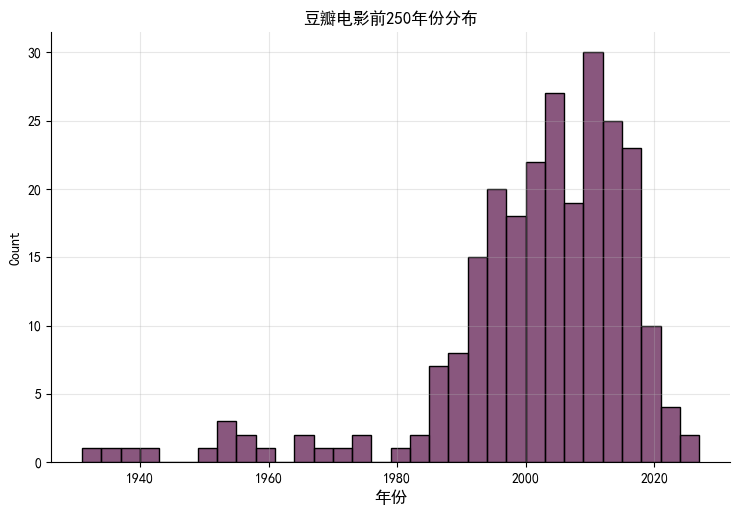

In [157]:
# 数据可视化
colors = sns.color_palette('rocket',n_colors=7)

dis_year = sns.displot(douban, x='年份', binwidth=3,
                       height=5, aspect=1.5, color=colors[1])
plt.grid(True, alpha=0.3)
dis_year.set_xlabels(size =12)
plt.title('豆瓣电影前250年份分布')

Text(0.5, 1.0, '豆瓣电影前250类型分布')

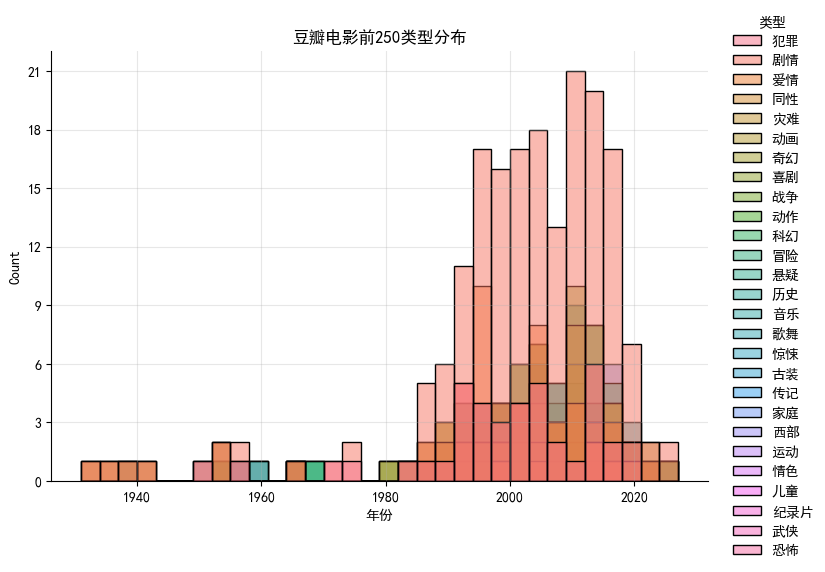

In [158]:
sns.displot(x='年份', data=year_kind, hue='类型',
            binwidth=3, height=5, aspect=1.5)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.title('豆瓣电影前250类型分布')

Text(0.5, 1.0, '豆瓣电影前250国家分布')

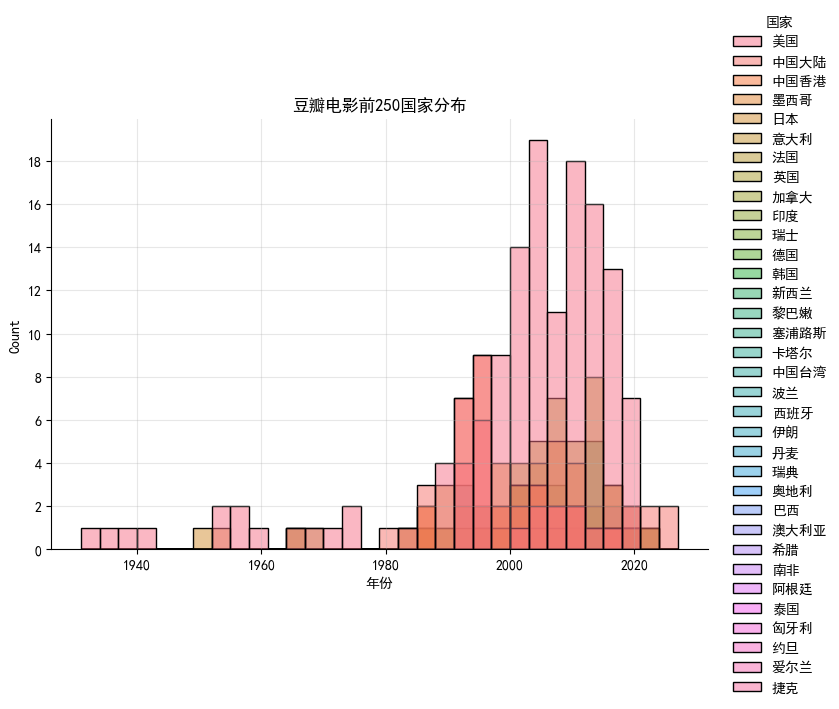

In [153]:
sns.displot(x='年份', data=year_country, hue='国家',
            binwidth=3, height=5, aspect=1.5)
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.grid(True, alpha=0.3)
plt.title('豆瓣电影前250国家分布')